## Chemical kinetics model

Modeling the chemical reaction system:

$A + B  \rightarrow C + F$

$A + C  \rightarrow D + F$

$A + D  \rightarrow E + F$

where the unknown parameters are the reaction rate coefficients.

See https://mjlaine.github.io/mcmcstat/ex/himmelex.html

In [1]:
import numpy as np
import pandas as pd
from thetafit import Parameter, optimize, sample
from thetafit.utils import McmcOptions, jacob
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
data = {
    'time': np.array([0, 4.50, 8.67, 12.67, 17.75, 22.67, 27.08, 32.00, 36.00, 46.33, 57.00, 69.00, 
                      76.75, 90.00, 102.00, 108.00, 147.92, 198.00, 241.75, 270.25, 326.25, 418.00,
                      501.00]),
    'A': np.array([0.02090, 0.01540, 0.01422, 0.01335, 0.01232, 0.01181, 0.01139, 0.01092, 0.01054, 
                   0.00978, 0.009157, 0.008594, 0.008395, 0.007891, 0.007510, 0.007370, 0.006646, 
                   0.005883, 0.005322, 0.004960, 0.004518, 0.004075, 0.003715]),
    'y0': np.array([0.02090, 0.0209/3, 0, 0, 0]),
    'sig2': 1.0
}

In [3]:
def himmelfun(theta, time, y0):
    
    def himmelode(y, t, theta):
        
        A, B, C, D, E = y
        
        ydot = [
            -theta['k1']*A*B - theta['k2']*A*C - theta['k3']*A*D,
            -theta['k1']*A*B,
            theta['k1']*A*B - theta['k2']*A*C,
            theta['k2']*A*C - theta['k3']*A*D,
            theta['k3']*A*D
        ]
        
        return ydot
    
    sol = odeint(himmelode, y0, time, args=(theta,))
        
    return sol

In [4]:
th0 = {'k1': 15., 'k2': 1.5, 'k3': 0.3}

In [5]:
y0 = himmelfun(th0, data['time'], data['y0'])

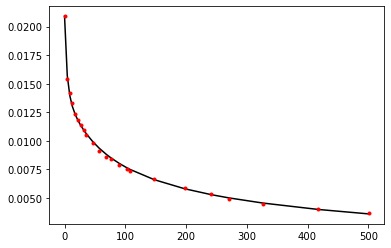

In [6]:
plt.figure()

plt.plot(data['time'], y0[:,0], 'k-')
plt.plot(data['time'], data['A'], 'r.')

plt.show()

In [7]:
himmelss = lambda theta, data: sum((data['A']-himmelfun(theta, data['time'], data['y0'])[:,0])**2/data['sig2'])

In [8]:
params = [
    Parameter('k1', init=th0['k1'], minimum=0),
    Parameter('k2', init=th0['k2'], minimum=0),
    Parameter('k3', init=th0['k3'], minimum=0)
]

In [9]:
thopt, optres = optimize(himmelss, data, params, method='Nelder-Mead')

/home/solant/.leanheat-ic/conda/envs/thetafit/lib/python3.9/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


In [10]:
thopt

{'k1': 14.393625591589135, 'k2': 1.5665290445554023, 'k3': 0.29038977942674843}

In [11]:
mse = optres.fun/(len(data['A'])-3)
data['sig2'] = mse

In [12]:
qcov = np.diag((0.05*np.abs(optres.x))**2)
options = McmcOptions(nsimu=2000, qcov=qcov, adaptint=100, printint=100)

res, chain, sschain = sample(himmelss, data, params, options)

Sampling these parameters:
name	start	[min,max]
k1	15.0	[0,inf]
k2	1.5	[0,inf]
k3	0.3	[0,inf]
i: 100, rejected: 73.0%, out of bounds: 0.0%
i: 200, rejected: 73.5%, out of bounds: 0.0%
i: 300, rejected: 73.0%, out of bounds: 0.0%
i: 400, rejected: 71.5%, out of bounds: 0.0%
i: 500, rejected: 69.4%, out of bounds: 0.0%
i: 600, rejected: 68.5%, out of bounds: 0.0%
i: 700, rejected: 69.3%, out of bounds: 0.0%
i: 800, rejected: 69.5%, out of bounds: 0.0%
i: 900, rejected: 69.1%, out of bounds: 0.0%
i: 1000, rejected: 70.0%, out of bounds: 0.0%
i: 1100, rejected: 70.4%, out of bounds: 0.0%
i: 1200, rejected: 71.2%, out of bounds: 0.0%
i: 1300, rejected: 70.9%, out of bounds: 0.0%
i: 1400, rejected: 71.1%, out of bounds: 0.0%
i: 1500, rejected: 70.5%, out of bounds: 0.0%
i: 1600, rejected: 70.6%, out of bounds: 0.0%
i: 1700, rejected: 70.1%, out of bounds: 0.0%
i: 1800, rejected: 70.1%, out of bounds: 0.0%
i: 1900, rejected: 70.3%, out of bounds: 0.0%


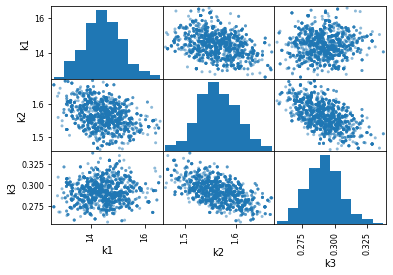

In [13]:
pd.plotting.scatter_matrix(chain);